# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [2]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  5.422137975692749


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [5]:
N = imgs0.shape[0]
imgs = imgs0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [7]:
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])

### Create the grids

In [8]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [9]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [10]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


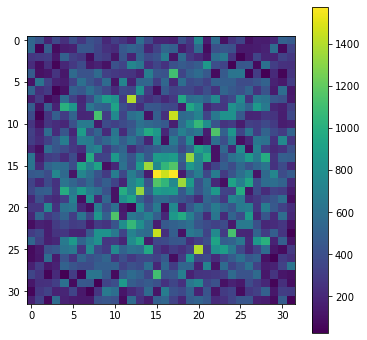

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

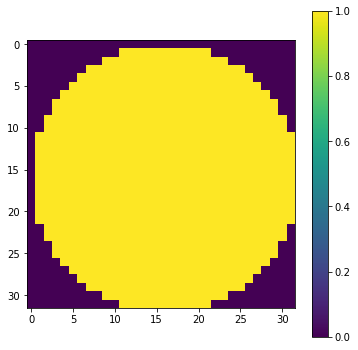

In [12]:
centre = (0,0,0)
radius = 0.05
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Estimate the noise

First, decide on the dimensions of the empty corners to use for noise estimation:

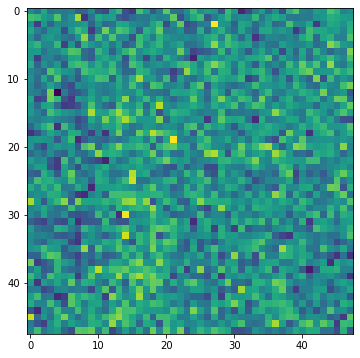

In [13]:
N_noise = 48
plt.imshow(jnp.mean(imgs0[:,:N_noise,:N_noise], axis=0))

Text(0.5, 1.0, 'Estimated noise')

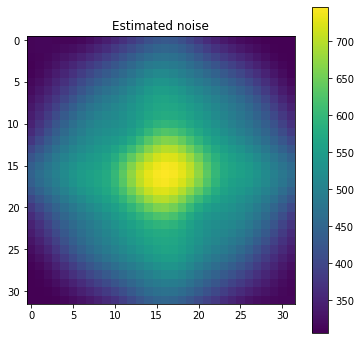

In [14]:
sigma_noise_estimated = estimate_noise_imgs(imgs0, nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

#### A quadratic noise model, fitted on the estimated one, for fun

Text(0.5, 1.0, 'Quadratic noise approximation')

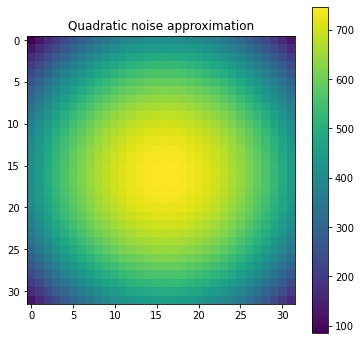

In [15]:
x_freq = jnp.fft.fftfreq(x_grid[1].astype(np.int64), 1/(x_grid[1] * x_grid[0]))
X,Y = jnp.meshgrid(x_freq, x_freq)
C = (jnp.max(sigma_noise_estimated)-jnp.min(sigma_noise_estimated))*1.5/jnp.max(X**2+Y**2)
sigma_noise_quadratic = jnp.max(sigma_noise_estimated) -(X**2 + Y**2)* C 
plt.imshow(jnp.fft.fftshift(sigma_noise_quadratic)); plt.colorbar()
plt.title('Quadratic noise approximation')

#### Average radially

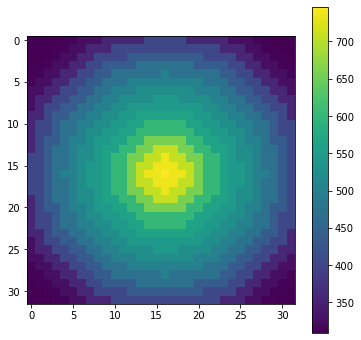

In [16]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)

plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

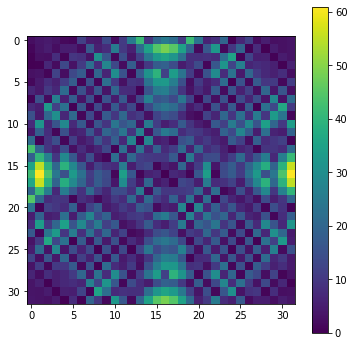

In [17]:
plt.imshow(jnp.fft.fftshift(jnp.abs(sigma_noise_avg-sigma_noise_estimated))); plt.colorbar()

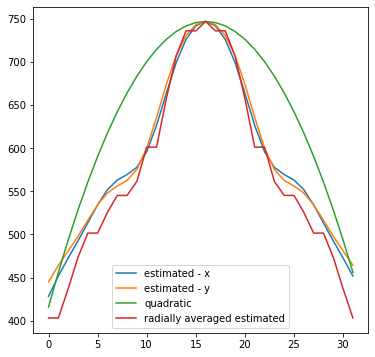

In [18]:
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[0,:]))
plt.plot(jnp.fft.fftshift(sigma_noise_quadratic[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_avg[:,0]))
plt.legend(['estimated - x', 'estimated - y', 'quadratic', 'radially averaged estimated'])

In [19]:
sigma_noise = sigma_noise_avg.reshape(-1)

### Delete the real images
Since we only work with the Fourier ones from now on.

In [20]:
del(imgs0)
del(imgs)

### Ab initio

In [21]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [22]:
#sys.stdout = sys.__stdout__

Fourier radius: 0.05021972132474
Starting radius: 0.01
Frequency marching step size: 0.005436444304774993
Number of frequency marching steps: 8
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 1.6085479337488898e-07
  sgd epoch 10: mean gradient = 1.0716669828543038e-08
  sgd epoch 20: mean gradient = 2.1692345063898062e-08
  sgd epoch 30: mean gradient = 1.4375136089033208e-08
  sgd epoch 40: mean gradient = 1.6814460816531925e-08
  sgd epoch 50: mean gradient = 1.4099417076782408e-08
  sgd epoch 60: mean gradient = 6.059686137349495e-09


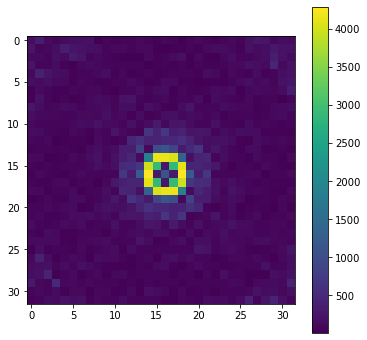

Iter  0
  MC sample 20 , loss = 19.988111007877617
  MC sample 40 , loss = 19.96644777524432
  MC sample 60 , loss = 19.982548422158654
  MC sample 80 , loss = 19.979467694494286
  Time orientations sampling = 3.860736131668091
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 20.407407513249233
  Time vol optimisation = 5.6675286293029785
2022-02-25 11:37:00.564111
  nx = 8


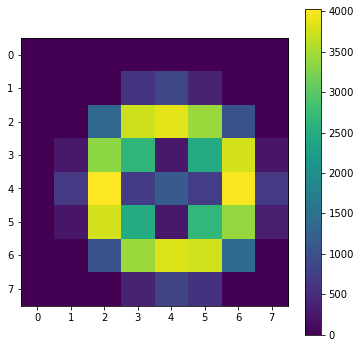

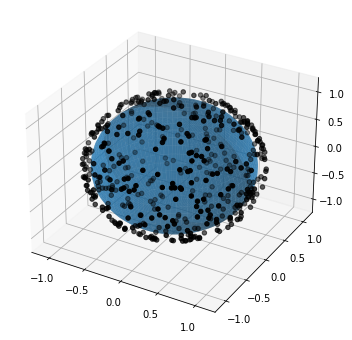

Iter  1
  MC sample 20 , loss = 35.54064598693251
  MC sample 40 , loss = 35.55251036088177
  MC sample 60 , loss = 35.54949216860524
  MC sample 80 , loss = 35.5512250572567
  Time orientations sampling = 4.725275278091431
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 35.74951771865702
  Time vol optimisation = 7.236221075057983
Iter  2
  MC sample 20 , loss = 35.32140731966562
  MC sample 40 , loss = 35.32852200590217
  MC sample 60 , loss = 35.317746950412506
  MC sample 80 , loss = 35.317221680344005
  Time orientations sampling = 4.718594074249268
  Iter 20 , a =  0.9999834033094593
  MC sample 20 , loss (of mean) = 35.716356610982686
  Time vol optimisation = 6.4416704177856445
Iter  3
  MC sample 20 , loss = 35.29158613347538
  MC sample 40 , loss = 35.289622499302716
  MC sample 60 , loss = 35.28298335070665
  MC sample 80 , loss = 35.28526443949325
  Time orientations sampling = 4.667522192001343
  Iter 20 , a =  0.9999270394112434
  MC sample 20 , loss (of mean) = 35

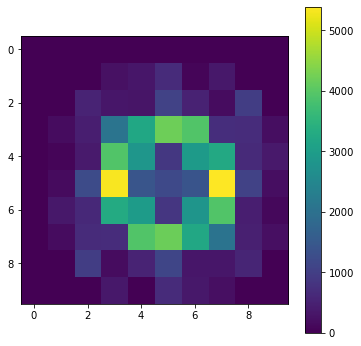

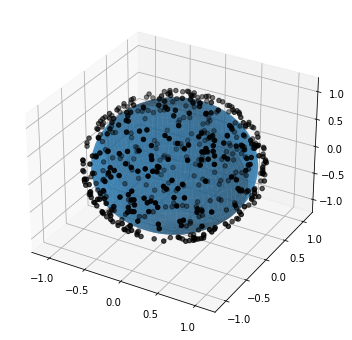

Iter  9
  MC sample 20 , loss = 65.50622674169745
  MC sample 40 , loss = 65.48591747375963
  MC sample 60 , loss = 65.53001700275288
  MC sample 80 , loss = 65.52647690550442
  Time orientations sampling = 6.531094074249268
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 65.14513986767142
  Time vol optimisation = 9.108148097991943
Iter  10
  MC sample 20 , loss = 64.42504341964128
  MC sample 40 , loss = 64.36188269324859
  MC sample 60 , loss = 64.39875574728116
  MC sample 80 , loss = 64.3727599394445
  Time orientations sampling = 6.530752182006836
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 64.69233114697637
  Time vol optimisation = 9.121838808059692
Iter  11
  MC sample 20 , loss = 63.96259850913653
  MC sample 40 , loss = 63.977957828173295
  MC sample 60 , loss = 63.95461333897129
  MC sample 80 , loss = 63.94175330420827
  Time orientations sampling = 6.496917247772217
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 64.33413207730405
  Time vol optim

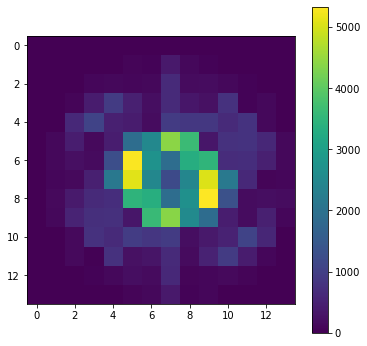

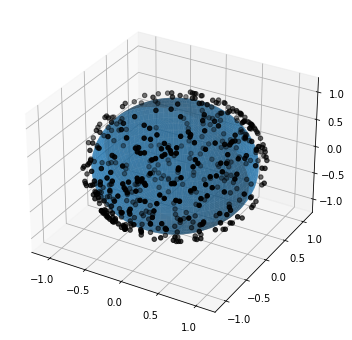

Iter  17
  MC sample 20 , loss = 105.09890093074165
  MC sample 40 , loss = 105.11003637708362
  MC sample 60 , loss = 105.11624678577189
  MC sample 80 , loss = 105.1451823404889
  Time orientations sampling = 7.959523916244507
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 105.3206655330691
  Time vol optimisation = 12.23658037185669
Iter  18
  MC sample 20 , loss = 104.56325489364575
  MC sample 40 , loss = 104.56424299572681
  MC sample 60 , loss = 104.55075189774067
  MC sample 80 , loss = 104.51845593601867
  Time orientations sampling = 7.996179819107056
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 104.7982152850479
  Time vol optimisation = 12.955128908157349
Iter  19
  MC sample 20 , loss = 103.9871577915646
  MC sample 40 , loss = 103.94384335612968
  MC sample 60 , loss = 103.92469841390076
  MC sample 80 , loss = 103.89520545822275
  Time orientations sampling = 8.080212593078613
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 104.22018410459594
  T

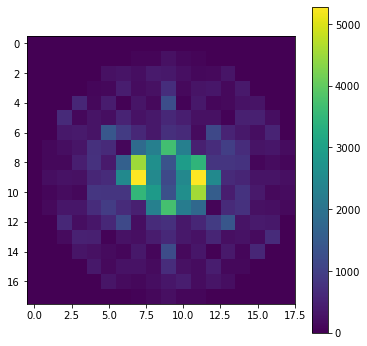

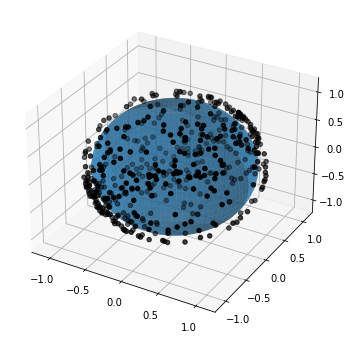

Iter  25
  MC sample 20 , loss = 155.34540574270622
  MC sample 40 , loss = 155.32895383127078
  MC sample 60 , loss = 155.3357066898868
  MC sample 80 , loss = 155.30946429728002
  Time orientations sampling = 10.002363920211792
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 154.7274112742993
  Time vol optimisation = 19.14413356781006
Iter  26
  MC sample 20 , loss = 153.80664911389505
  MC sample 40 , loss = 153.6906358747677
  MC sample 60 , loss = 153.58877881737084
  MC sample 80 , loss = 153.54284314770737
  Time orientations sampling = 10.59716248512268
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 153.78398699697965
  Time vol optimisation = 15.938848495483398
Iter  27
  MC sample 20 , loss = 152.90851518434266
  MC sample 40 , loss = 152.83543346230678
  MC sample 60 , loss = 152.75059673871746
  MC sample 80 , loss = 152.70327817495502
  Time orientations sampling = 9.872354745864868
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 153.08105791770654
 

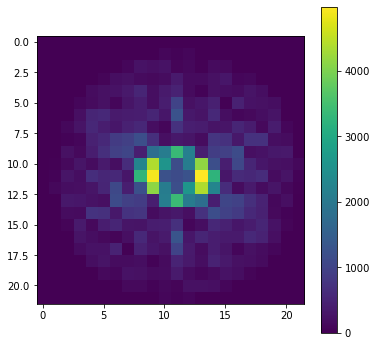

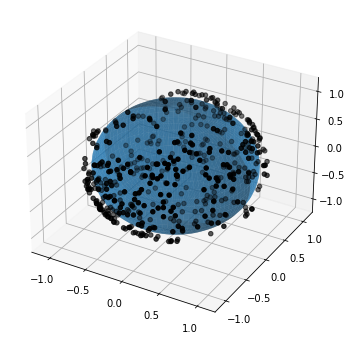

Iter  33
  MC sample 20 , loss = 207.0865170289905
  MC sample 40 , loss = 207.0355267882538
  MC sample 60 , loss = 207.0191244254164
  MC sample 80 , loss = 206.99281273041996
  Time orientations sampling = 11.667435884475708
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 206.16310029484185
  Time vol optimisation = 20.191873788833618
Iter  34
  MC sample 20 , loss = 205.12169652417552
  MC sample 40 , loss = 205.05460259830005
  MC sample 60 , loss = 205.0032252417094
  MC sample 80 , loss = 204.95737916988008
  Time orientations sampling = 11.529911756515503
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 205.44859656027373
  Time vol optimisation = 17.771164655685425
Iter  35
  MC sample 20 , loss = 204.51030651908144
  MC sample 40 , loss = 204.46106117129693
  MC sample 60 , loss = 204.41159808178764
  MC sample 80 , loss = 204.3588411044983
  Time orientations sampling = 11.748046636581421
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 204.9757546650706
 

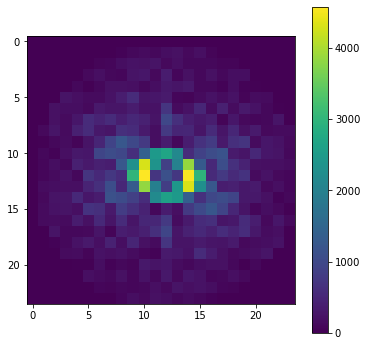

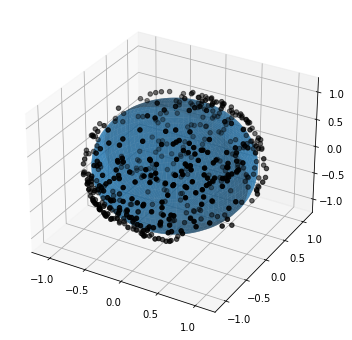

Iter  41
  MC sample 20 , loss = 274.2963551139964
  MC sample 40 , loss = 274.2678996293828
  MC sample 60 , loss = 274.247838583883
  MC sample 80 , loss = 274.2384358240433
  Time orientations sampling = 13.877345561981201
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 273.4021663144918
  Time vol optimisation = 25.170698642730713
Iter  42
  MC sample 20 , loss = 272.34682247722475
  MC sample 40 , loss = 272.3196941956443
  MC sample 60 , loss = 272.2969121229616
  MC sample 80 , loss = 272.26631678210845
  Time orientations sampling = 13.824207067489624
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 272.9217018320886
  Time vol optimisation = 22.62267541885376
Iter  43
  MC sample 20 , loss = 271.9515520592549
  MC sample 40 , loss = 271.913743936737
  MC sample 60 , loss = 271.88892448619583
  MC sample 80 , loss = 271.86640641471547
  Time orientations sampling = 13.847062110900879
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 272.617842870308
  Time vol

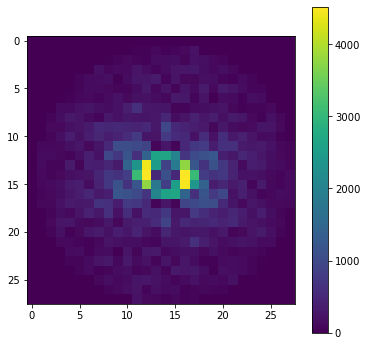

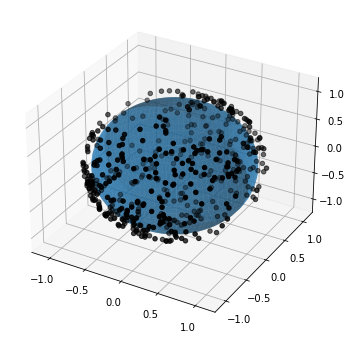

Iter  49
  MC sample 20 , loss = 357.6705758458463
  MC sample 40 , loss = 357.65523324261915
  MC sample 60 , loss = 357.64369191823914
  MC sample 80 , loss = 357.6318773334046
  Time orientations sampling = 17.043590784072876
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 356.69550986064024
  Time vol optimisation = 31.252574920654297
Iter  50
  MC sample 20 , loss = 355.6109003876375
  MC sample 40 , loss = 355.5897660105806
  MC sample 60 , loss = 355.5738802522863
  MC sample 80 , loss = 355.55665091653367
  Time orientations sampling = 17.000176668167114
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 356.30367104364535
  Time vol optimisation = 30.001667976379395
Iter  51
  MC sample 20 , loss = 355.3066081348417
  MC sample 40 , loss = 355.2918218543071
  MC sample 60 , loss = 355.27004752540165
  MC sample 80 , loss = 355.25249972374365
  Time orientations sampling = 17.133782625198364
  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 356.0610576091588
  T

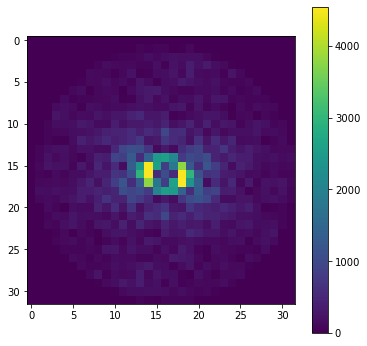

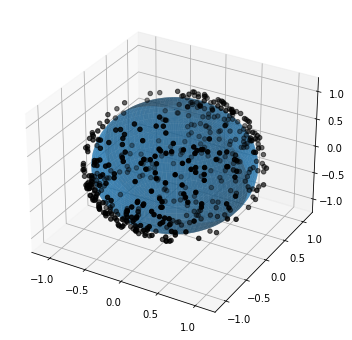

In [28]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


# The number of iterations doesn't matter, 
# since it stops when the volume is nx x nx x nx.
N_samples = 40000
N_iter = 10000


radius0 = 0.01
#radius0 = 0.03
alpha = 1e-9  # <--- this is the working one
#alpha = 0.001


# The number of cg or sgd iterations also doesn't matter,
# since it stops when it reaches the desired accuracy.
N_cg_iter = 100000
eps_cg = 3e-5

N_sgd_iter = 100000
batch_size = 300
learning_rate = 1e6
#learning_rate = 1
eps_gd = 1e-8 
#eps_gd = 1e-4
P = None

use_sgd = True

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

N_samples_angles = 100
N_samples_vol = 21    

# HMC params
dt = 5
L = 4

#sigma_noise = jnp.ones(sigma_noise.shape)
    
out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])

#v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec = ab_initio_mcmc(key, project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, learning_rate, batch_size, P, N_samples_angles, N_samples_vol, dt, L, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)

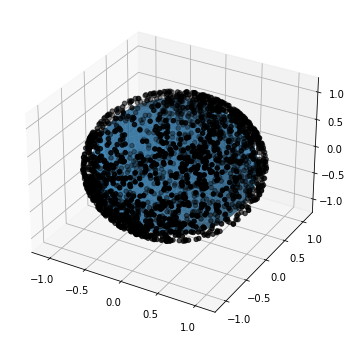

In [32]:
plot_angles(angles_rec[:2000])

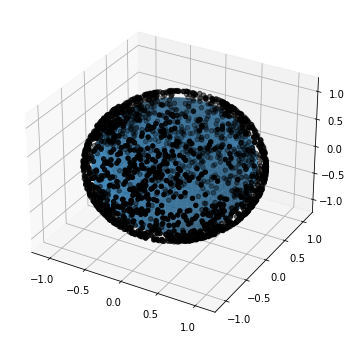

In [24]:
plot_angles(angles_rec[:2000])

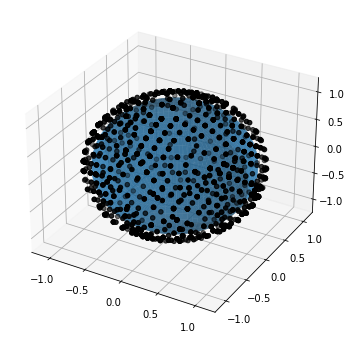

In [33]:
plot_angles(angles[:2000])

### MCMC vol

In [40]:
alpha

1e-09

In [69]:
#alpha = 1e-10
alpha = 1e-6

radius = 0.8 # for nx=32
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_batched(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise))

In [70]:
N_mc_samples = 100
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
#v0 = jnp.zeros([nx,nx,nx])*1j
proposal_params_mala = {"tau" : 0.005}
proposal_params_hmc = {"dt" : 0.5, "L" : 10, "M" : M, "gradLogPi" : gradLogPi}

v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)

  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 505.10920640787054
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 505.10847404602686
  Iter 60 , a =  0.9999552686009344
  MC sample 60 , loss (of mean) = 505.1083227447114
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 505.1082657757369


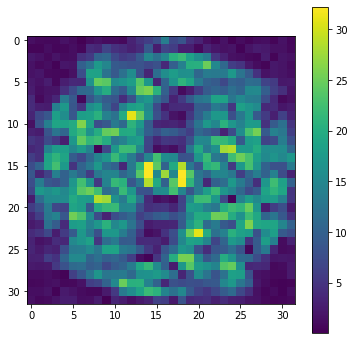

In [71]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

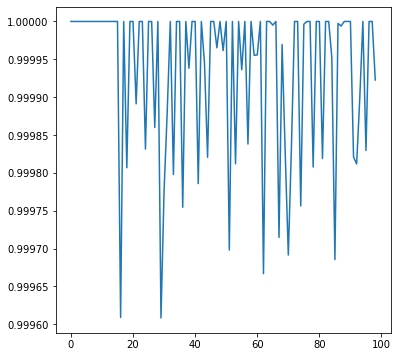

In [72]:
plt.plot(r_hmc)

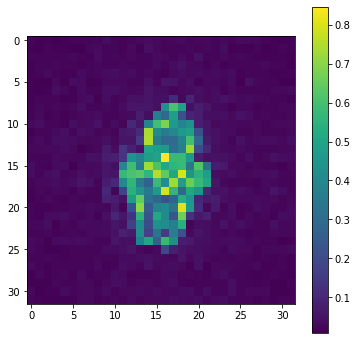

In [73]:
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))
mip_z(v_hmc_r)
plt.colorbar()

In [74]:
with mrcfile.new('../data/reconstruction_data_hmc_vol2.mrc', overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

### CG - choosing $\alpha$

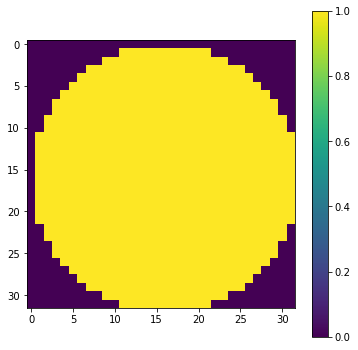

In [101]:
centre = (0,0,0)
radius = 0.05
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [102]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

sigma noise min = 309.3671569824219
sigma noise max = 746.6329956054688
sigma noise mean = 471.57769733667374


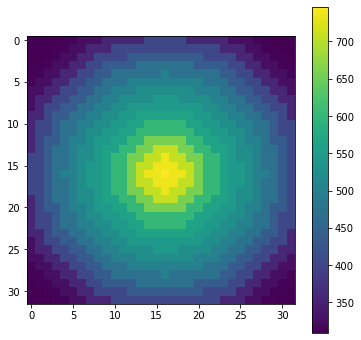

In [103]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [104]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [105]:
N_iter = 50100
eps = 3e-5
#eps = 1e-5
#eps = 1e-3
v0 = jnp.zeros([nx,nx,nx])* 1j
alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [106]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1.1e-06
  cg iter 0 ||r|| = 0.00010695120434695287
  cg iter 10 ||r|| = 2.5394858256747326e-05
  fid = 0.7798959943947431
  reg = 119.5293245794078
  loss = 0.39205171330996913
  Time = 17.003379344940186
alpha = 1e-05
  cg iter 0 ||r|| = 1.2879246612488046e-05
  fid = 0.7873374069026533
  reg = 1.6733864760699484
  loss = 0.3939364452874978
  Time = 9.497883796691895
alpha = 0.0001
  cg iter 0 ||r|| = 1.3016424168687495e-06
  fid = 0.7883053153586516
  reg = 0.017092229741083105
  loss = 0.3941800052469115
  Time = 9.46831727027893
alpha = 0.001
  cg iter 0 ||r|| = 1.3030302815313394e-07
  fid = 0.7884038079445588
  reg = 0.00017128698048380446
  loss = 0.39420464456396714
  Time = 10.379130363464355
alpha = 0.01
  cg iter 0 ||r|| = 1.303169230788465e-08
  fid = 0.7884136744890425
  reg = 1.713235129702346e-06
  loss = 0.3942071113621421
  Time = 9.595714330673218
alpha = 0.1
  cg iter 0 ||r|| = 1.303183127327354e-09
  fid = 0.7884146613166224
  reg = 1.7132716686168196e-08
  

KeyboardInterrupt: 

ValueError: x and y must have same first dimension, but have shapes (10,) and (6,)

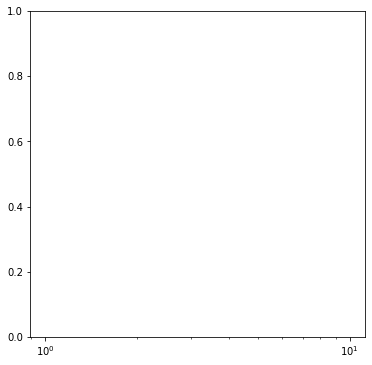

In [108]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

In [ ]:
plt.plot(fids)

In [ ]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [109]:
def pixel_wise_fid_fun(v, slice_func_array, angles_, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [110]:
alphas[alpha_idx]

DeviceArray(1.1e-06, dtype=float64)

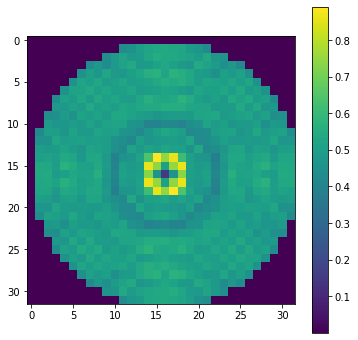

In [111]:
pw_fid = pixel_wise_fid_fun(vcgs[alpha_idx], slice_func_array, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

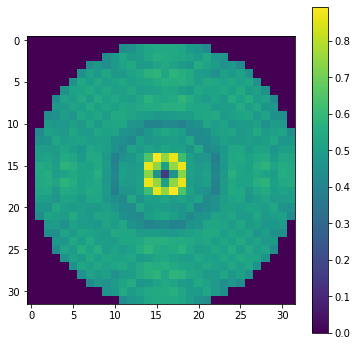

In [112]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [113]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

0


In [114]:
#alpha_idx = 2

1.1e-06


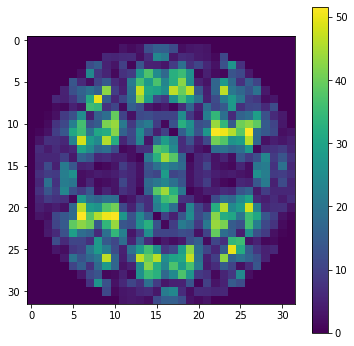

In [115]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

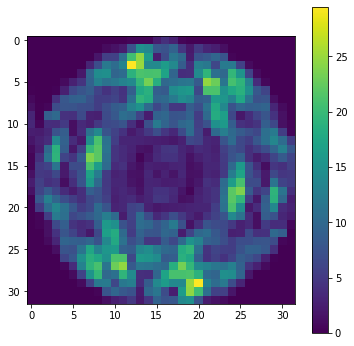

In [116]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

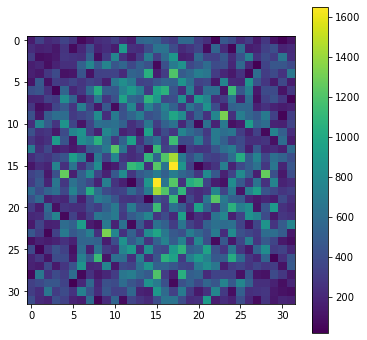

In [117]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

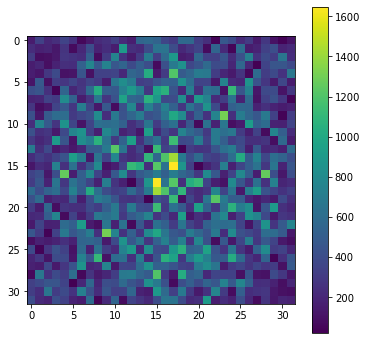

In [118]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [119]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

Text(0.5, 1.0, 'Reconstruction MIP')

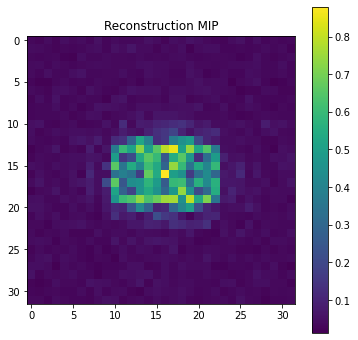

In [120]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [93]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [94]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

(10, 32)

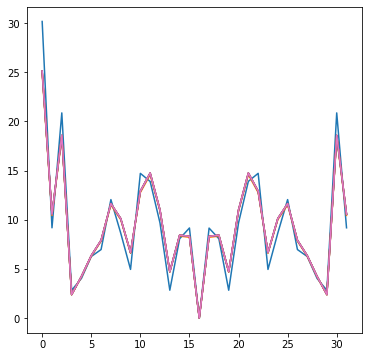

In [124]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*9)
plt.plot(jnp.abs(vcgs_s[2])*90)
plt.plot(jnp.abs(vcgs_s[3])*900)
plt.plot(jnp.abs(vcgs_s[6])*9e5)
plt.plot(jnp.abs(vcgs_s[8])*9e7)
plt.plot(jnp.abs(vcgs_s[10])*9e8)

### FSC, orientations, standard deviation for each voxel etc

In [137]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [138]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [127]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 100)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


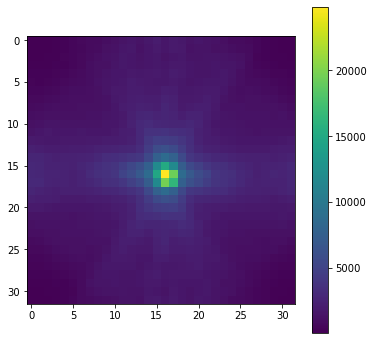

In [128]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [129]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

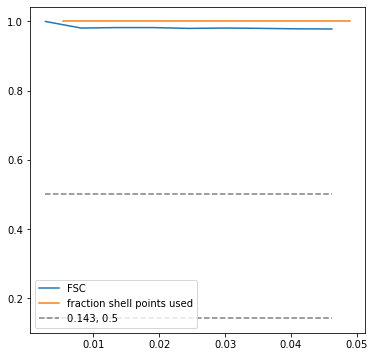

In [139]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

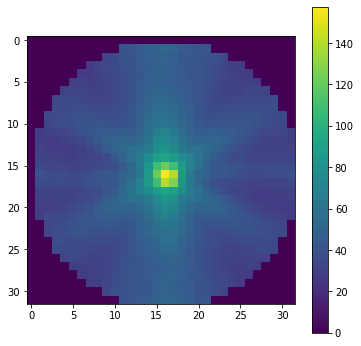

In [140]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

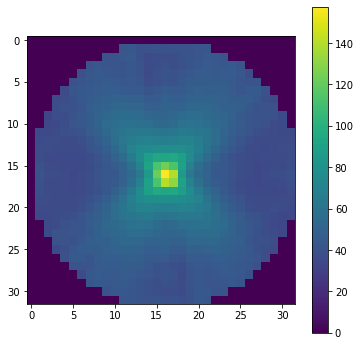

In [141]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

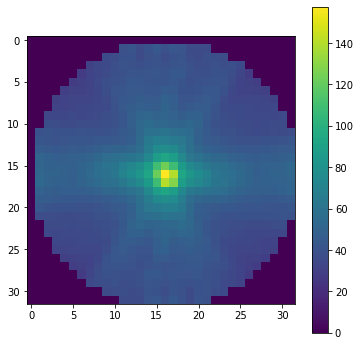

In [142]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [149]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [152]:
jnp.min(jnp.abs(omega))

DeviceArray(0.001, dtype=float64)

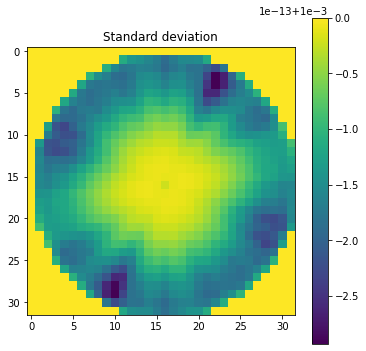

In [171]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

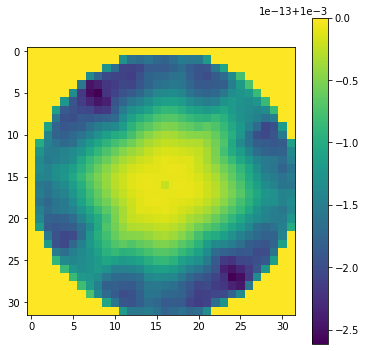

In [172]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

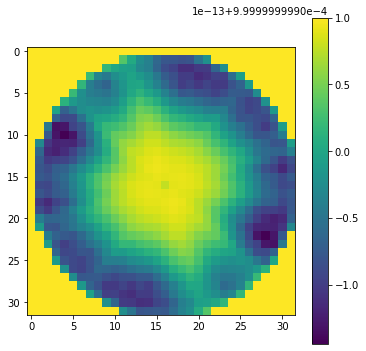

In [173]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

1e-06
1.000001
1e-06


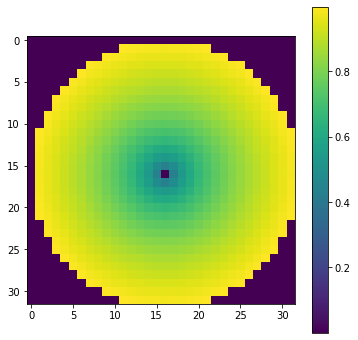

In [174]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

0.02275106763759302
1.0
0.0


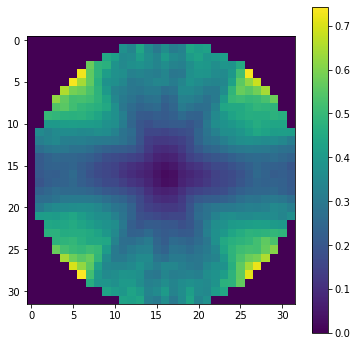

In [175]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [176]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [196]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
alphas = [1e-10, 1e-9, 1e-8, 1e-7]

angles_gd = angles_rec

In [197]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-10
  sgd epoch 0: mean gradient = 1.4729407511529204e-07
  sgd epoch 50: mean gradient = 6.929328984682533e-09
  fid = 0.7156186797013532
  reg = 81203.15309067581
  loss = 0.35793926489562167
  Time = 21.56503438949585
alpha = 1e-09
  sgd epoch 0: mean gradient = 1.478003812584484e-07
  sgd epoch 50: mean gradient = 7.60058385263992e-09
  fid = 0.7158457744341501
  reg = 69454.35128632141
  loss = 0.3590341568376562
  Time = 21.490625143051147
alpha = 1e-08
  sgd epoch 0: mean gradient = 1.41740796721962e-07
  sgd epoch 50: mean gradient = 1.1299338934994461e-08
  sgd epoch 100: mean gradient = 2.5887754490609068e-08
  sgd epoch 150: mean gradient = 1.2294315039249511e-09
  fid = 0.7211072722198489
  reg = 30100.955157007047
  loss = 0.36536978893504557
  Time = 40.72334885597229
alpha = 1e-07
  sgd epoch 0: mean gradient = 6.3791124078498e-08
  sgd epoch 50: mean gradient = 2.4142365269046486e-08
  sgd epoch 100: mean gradient = 3.794820156606282e-08
  sgd epoch 150: mean 

In [203]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

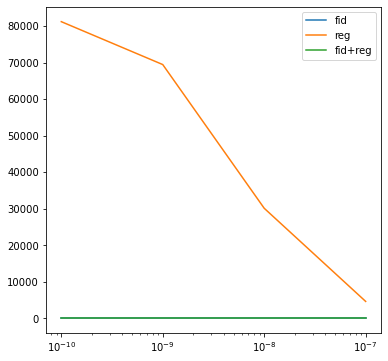

In [204]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

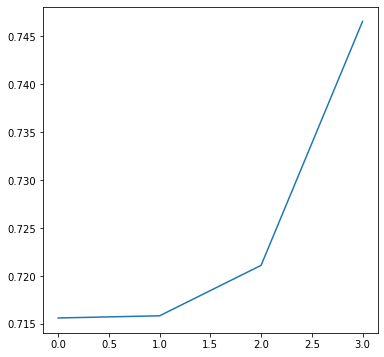

In [205]:
plt.plot(fids)

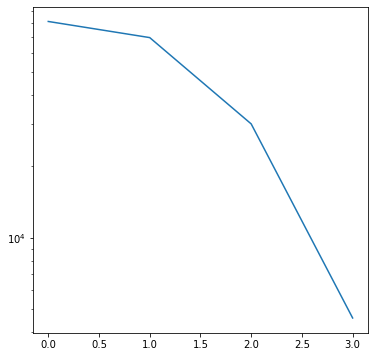

In [206]:
plt.semilogy(regs)

In [207]:
alphas[2]

DeviceArray(1.e-08, dtype=float64)

In [208]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

0.6971769473547622


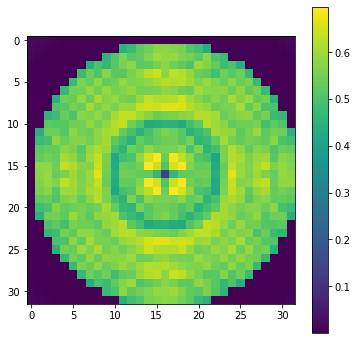

In [209]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

0.6971769473547622


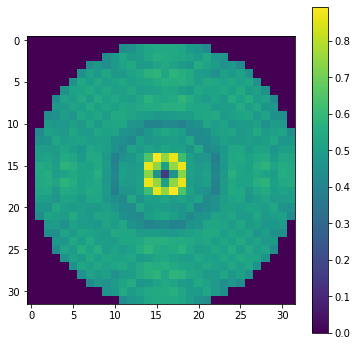

In [210]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

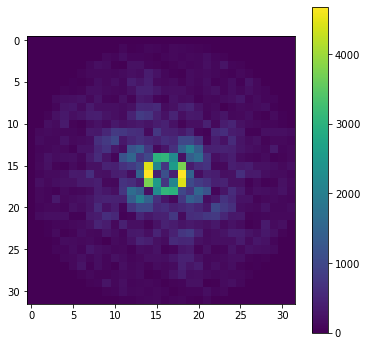

In [213]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

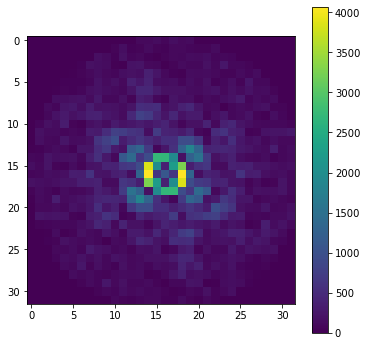

In [214]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

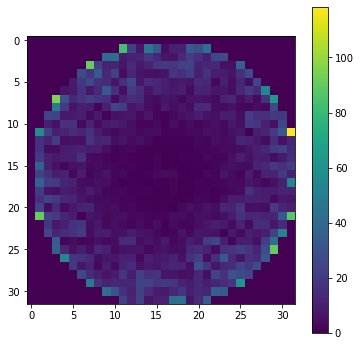

In [217]:
err = vgds[1] - v_rec
plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

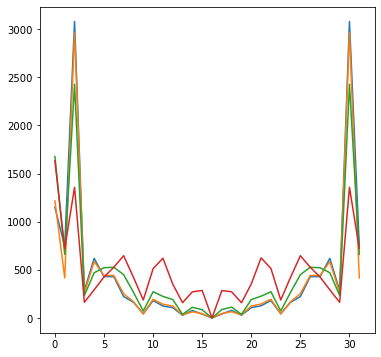

In [227]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


Text(0.5, 1.0, 'Reconstruction MIP')

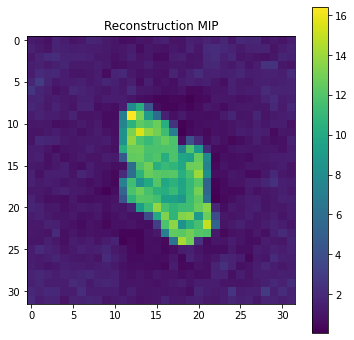

In [228]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

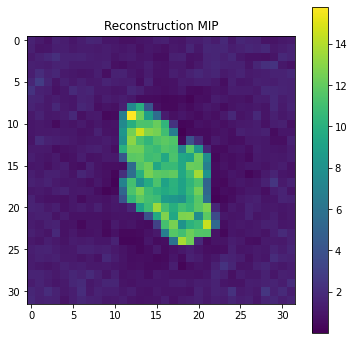

In [229]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

In [240]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [231]:
idx = 100

In [236]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

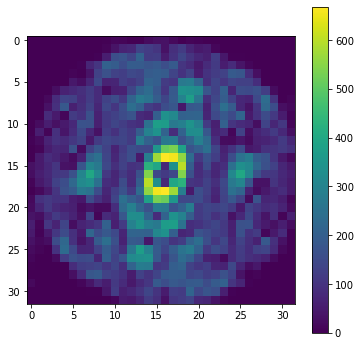

In [237]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([32,32])))); plt.colorbar()

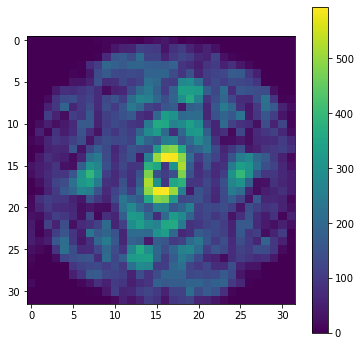

In [238]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

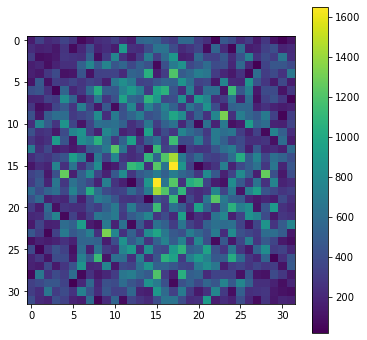

In [239]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()